# **Absenteeism Data Analysis & Fairness Evaluation Project**
### **Author: Muhtasim Fuad Chowdhury**


This project explores student absenteeism via algorithmic fairness using a real-world school dataset (absenteeism.csv). A diagnostic predictive model is built to identify patterns associated with excessive absenteeism and to assess whether predictions differ systematically across demographic groups (age and sex).

The analysis combines data preprocessing, exploratory analysis, and logistic regression modeling to evaluate both predictive performance and fairness. Multiple fairness metrics (Demographic Parity, Equal Opportunity, and Error-Rate Disparities) are used to highlight how model behavior can differ across groups. This project emphasizes trade-offs between accuracy and fairness, and examines how fairness metrics fare when demographic information is used directly in predictive systems.

An interactive Tableau dashboard was created to examine absenteeism distributions and high-risk rates across age and sex groups to complement static visualizations. This allows for a visual explanation of the disparities explored, making findings more accessible to stakeholders.



In [1]:
'''
Imports and Configurations
'''

# Libraries and Visualization
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

# Warnings
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Scikit-learn
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Reproducibility
rng_seed = 42
rng = np.random.default_rng(rng_seed)

# Data

In [2]:
'''
Loading the data, carrying out some pre-processing, and inspecting the data to understand what exploratory steps to take
'''

df_init = pd.read_csv("absenteeism.csv")

print("Shape: ", df_init.shape)
df_init.head(5)
print(df_init[df_init["sex"]=="M"])
print(df_init[df_init["sex"]=="F"])

Shape:  (146, 5)
    ethnicity sex age learner_status  days_absent
0           A   M  F0             SL            2
1           A   M  F0             SL           11
2           A   M  F0             SL           14
3           A   M  F0             AL            5
4           A   M  F0             AL            5
..        ...  ..  ..            ...          ...
99          N   M  F3             AL           10
100         N   M  F3             AL           14
101         N   M  F3             AL           27
102         N   M  F3             AL           41
103         N   M  F3             AL           69

[66 rows x 5 columns]
    ethnicity sex age learner_status  days_absent
31          A   F  F0             SL            3
32          A   F  F0             AL            5
33          A   F  F0             AL           11
34          A   F  F0             AL           24
35          A   F  F0             AL           45
..        ...  ..  ..            ...          ...
141       

# Data Pre-processing

In [3]:
'''
Age and sex are treated as sensitive attributes for fairness evaluation
The outcome variable is a binary absenteeism risk label derived from days_absent
'''

cols_retain = ['age', 'sex', 'days_absent']
df = df_init[cols_retain].copy()

# Keep initial age group categorization
df['age_group_raw'] = df['age']

# Convert age into binary classification
df['age_group'] = df['age_group_raw'].map({
    'F0': 0, 'F1': 0,
    'F2': 1, 'F3': 1
})

# Drop rows with missing values
df = df.dropna()

df

,age,sex,days_absent,age_group_raw,age_group
0,F0,M,2,F0,0
1,F0,M,11,F0,0
2,F0,M,14,F0,0
3,F0,M,5,F0,0
4,F0,M,5,F0,0
...,...,...,...,...,...
141,F3,F,5,F3,1
142,F3,F,15,F3,1
143,F3,F,18,F3,1
144,F3,F,22,F3,1


In [4]:
'''
Ensure the outcome variable is numeric for modeling and evaluation
'''

# Invalid entries coerced to NaN
df['days_absent'] = pd.to_numeric(df['days_absent'], errors='coerce')

# Drop rows with missing values
df = df.dropna()

# Data Exploration

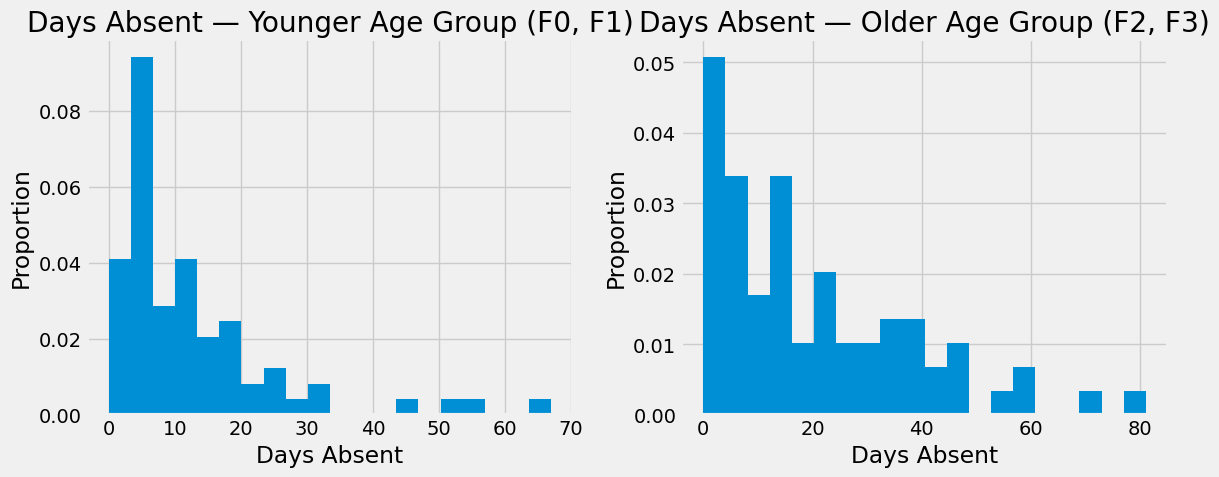

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
F0,27.0,14.851852,14.795279,0.0,5.00,11.0,20.0,67.0
F1,46.0,11.152174,11.640862,0.0,5.00,6.0,14.0,54.0
F2,40.0,21.050000,20.136649,0.0,5.75,14.0,33.0,81.0
F3,33.0,19.606061,15.974471,0.0,5.00,18.0,30.0,69.0


In [5]:
'''
Absenteeism by Age Group: Compare distribution of days absent across age-based subgroups (F0, F1: Younger Group, F2, F3: Older Group)
'''

df_young = df[df['age_group_raw'].isin(['F0', 'F1'])]
df_old = df[df['age_group_raw'].isin(['F2', 'F3'])]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Younger age group (F0, F1)
df_young['days_absent'].hist(density=True, bins=20, ax=ax1)
ax1.set_title('Days Absent — Younger Age Group (F0, F1)')
ax1.set_xlabel('Days Absent')
ax1.set_ylabel('Proportion')

# Older age group (F2, F3)
df_old['days_absent'].hist(density=True, bins=20, ax=ax2)
ax2.set_title('Days Absent — Older Age Group (F2, F3)')
ax2.set_xlabel('Days Absent')
ax2.set_ylabel('Proportion')

plt.tight_layout()
plt.show()

# Summary statistics by age
df.groupby('age')['days_absent'].describe()

### Evaluation:
The exploratory analysis shows clear differences in absenteeism patterns across age groups. Both younger (F0, F1) and older (F2, F3) students exhibit right-skewed distributions, indicating that most students miss relatively few days while a small subset accounts for high absenteeism. However, older age groups display higher average absenteeism and greater variability, with heavier tails and more extreme outliers, suggesting more heterogeneous risk profiles. These distributional differences do not imply causation but indicate that absenteeism outcomes are unevenly distributed across age groups, which may lead to differential model behavior across subpopulations. As a result, subsequent predictive modeling requires a fairness-aware evaluation to assess whether absenteeism risk is estimated equitably across age-based groups.

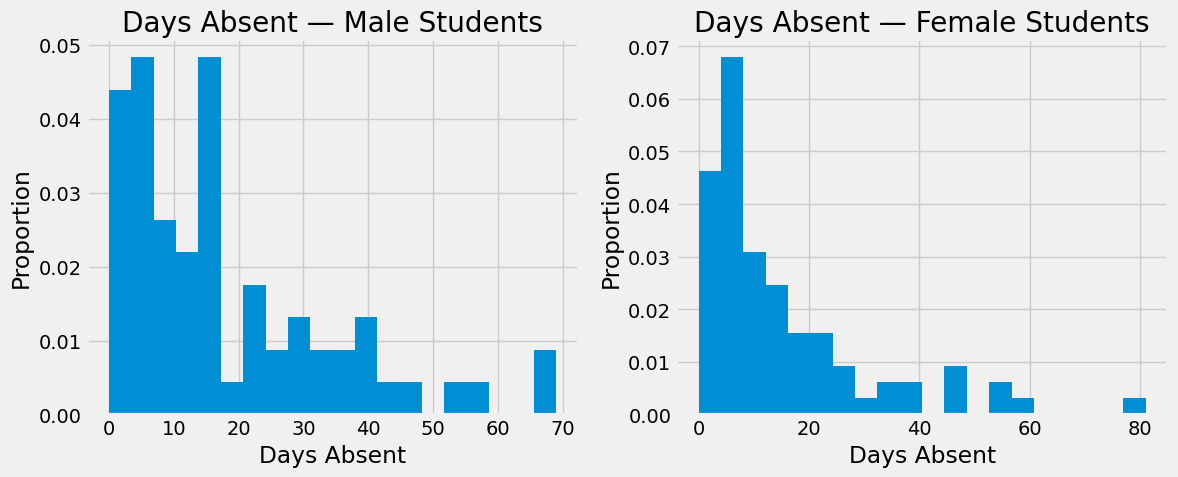

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
F,80.0,15.225000,15.931002,0.0,5.00,10.0,20.25,81.0
M,66.0,17.954545,16.634008,0.0,5.25,14.0,27.00,69.0


In [6]:
'''
Absenteeism by Sex: Compare distribution of days absent between male and female students
'''

df_male = df[df['sex'] == 'M']
df_female = df[df['sex'] == 'F']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Male students
df_male['days_absent'].hist(density=True, bins=20, ax=ax1)
ax1.set_title('Days Absent — Male Students')
ax1.set_xlabel('Days Absent')
ax1.set_ylabel('Proportion')

# Female students
df_female['days_absent'].hist(density=True, bins=20, ax=ax2)
ax2.set_title('Days Absent — Female Students')
ax2.set_xlabel('Days Absent')
ax2.set_ylabel('Proportion')

plt.tight_layout()
plt.show()

# Summary statistics by sex
df.groupby('sex')['days_absent'].describe()

### Evaluation:
The absenteeism distributions for male and female students are both right-skewed, indicating that most students miss relatively few days while a small number account for high absenteeism. Male students exhibit a higher average number of days absent and greater variability compared to female students, with heavier tails and more extreme values, suggesting more heterogeneous absenteeism patterns within this group. While these differences do not imply causal effects of sex on absenteeism, they highlight non-uniform outcome distributions across demographic groups. Such disparities underscore the importance of evaluating predictive models for potential differences in error rates and decision outcomes across sex-based subpopulations when assessing fairness.

# Fairness/Bias in the Dataset

In [7]:
'''
Define a binary absenteeism risk label: Students absent for more than 5 days are classified as high-risk, consistent with observed distributional skew and tail behavior
'''

Y = (df['days_absent'] > 5).astype(int)

# Examine class balance of the risk label
Y.value_counts(normalize=True)

,proportion
days_absent,
1,0.691781
0,0.308219


In [8]:
'''
Separate sensitive attributes for fairness evaluation
Define feature set for modeling
'''

X_demo = df[['age_group', 'sex']].copy()

# Exclude sensitive attributes and target variable
X = df.drop(columns=[
    'days_absent',
    'age',
    'age_group',
    'age_group_raw',
    'sex'
], errors='ignore')

print("Model features:", X.columns.tolist())
print("Sensitive attributes:", X_demo.columns.tolist())

Model features: []
Sensitive attributes: ['age_group', 'sex']


In [9]:
'''
Preprocessing:
  - Standard Scaler for numerical features
  - One-hot encoder for categorical features
'''

# Examine feature types in diagnostic dataset
X_demo.dtypes


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selector(dtype_exclude='object')),
        ('cat', OneHotEncoder(drop='first'), selector(dtype_include='object'))
    ]
)

In [10]:
'''
Diagnostic logistic regression model for fairness evaluation
'''

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])

In [11]:
'''
Train-test split for diagnostic model for fairness evaluation
'''

X_train, X_test, Y_train, Y_test = train_test_split(
    X_demo,
    Y,
    test_size=0.25,
    random_state=42,
    stratify=Y
)

# Fit diagnostic logistic regression model
model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d4e178de420>),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d4e17838380>)])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [12]:
'''
Generate predictions on the test set
'''

Y_pred = model.predict(X_test)

# Examine prediction distribution
pd.Series(Y_pred).value_counts(normalize=True)

,proportion
0,0.648649
1,0.351351


In [13]:
'''
Sensitive attributes aligned with the test set for fairness metrics
'''

A_test = X_test[['age_group', 'sex']].copy()

A_test.head()

,age_group,sex
111,0,F
104,0,F
132,1,F
66,1,F
82,0,M


In [14]:
'''
Convert predictions to DataFrame for index alignment
'''

Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=['y_pred'])
Y_pred.head()

,y_pred
111,0
104,0
132,0
66,0
82,1


In [15]:
'''
Classification performance on the test set for fairness evaluation
'''

print(classification_report(Y_test, Y_pred['y_pred']))

              precision    recall  f1-score   support

           0       0.25      0.55      0.34        11
           1       0.62      0.31      0.41        26

    accuracy                           0.38        37
   macro avg       0.43      0.43      0.38        37
weighted avg       0.51      0.38      0.39        37



In [16]:
"""
Compute True Positive Rate (TPR) for a sensitive group.
TPR = P(y_pred = 1 | y_true = 1, s_feature = s_value)
This metric is used in fairness analysis to evaluate Equal Opportunity across demographic groups.
"""

def tpr_metric(y_true, y_pred, x, s_feature, s_value):

    # Identify rows of sensitive group
    sub_idx = x[s_feature] == s_value

    # Subset true and predicted labels
    y_true_sub = y_true[sub_idx]
    y_pred_sub = y_pred[sub_idx].squeeze()

    # True positives
    tp = ((y_true_sub == 1) & (y_pred_sub == 1)).sum()

    # Actual Positives
    pos = (y_true_sub == 1).sum()

    tpr = tp / pos if pos != 0 else 0.0
    return tpr

In [17]:
"""
Compute False Positive Rate (FPR) for a sensitive group.
FPR = P(y_pred = 1 | y_true = 0, s_feature = s_value)
This metric is used in Equalized Odds and error parity analysis.
"""

def fpr_metric(y_true, y_pred, x, s_feature, s_value):

    # Identify rows of sensitive group
    sub_idx = x[s_feature] == s_value

    # Subset true and predicted labels
    y_true_sub = y_true[sub_idx]
    y_pred_sub = y_pred[sub_idx].squeeze()

    # False positives
    fp = ((y_true_sub == 0) & (y_pred_sub == 1)).sum()

    # Actual negatives
    neg = (y_true_sub == 0).sum()

    fpr = fp / neg if neg != 0 else 0.0
    return fpr

In [18]:
"""
Compute the rate of positive predictions for a sensitive group.
P(y_pred = 1 | s_feature = s_value)
This metric is used to evaluate Demographic Parity.
"""

def poslabel_metric(y_pred, x, s_feature, s_value):

    # Identify rows of sensitive group
    sub_idx = x[s_feature] == s_value

    # Subset predicted labels
    y_pred_sub = y_pred[sub_idx].squeeze()

    # Positive predictions
    pos_pred = (y_pred_sub == 1).sum()

    # Individuals in the group
    total = len(y_pred_sub)

    poslabel = pos_pred / total if total != 0 else 0.0
    return poslabel

In [19]:
'''
Fairness Metrics by Age Group
Sensitive attribute: age_group (0: young, 1: old)
'''

# Demographic Parity Difference
dp_age = (
    poslabel_metric(Y_pred, A_test, 'age_group', 0) -
    poslabel_metric(Y_pred, A_test, 'age_group', 1)
)
print("Age:\nDemographic Parity Difference:", dp_age)

# Equal Opportunity Difference (TPR difference)
eo_age = (
    tpr_metric(Y_test, Y_pred, A_test, 'age_group', 0) -
    tpr_metric(Y_test, Y_pred, A_test, 'age_group', 1)
)
print("Equal Opportunity Difference:", eo_age)

# Equalized Odds Difference (FPR difference)
fpr_age = (
    fpr_metric(Y_test, Y_pred, A_test, 'age_group', 0) -
    fpr_metric(Y_test, Y_pred, A_test, 'age_group', 1)
)
print("Equalized Odds Differences [TPR, FPR]:", [eo_age, fpr_age])

Age:
Demographic Parity Difference: 0.32352941176470584
Equal Opportunity Difference: 0.26190476190476186
Equalized Odds Differences [TPR, FPR]: [np.float64(0.26190476190476186), np.float64(0.4666666666666666)]


In [20]:
'''
Fairness Metrics by Sex
Sensitive attribute: sex (M: male, F: female)
'''

# Demographic Parity Difference
dp_sex = (
    poslabel_metric(Y_pred, A_test, 'sex', 'M') -
    poslabel_metric(Y_pred, A_test, 'sex', 'F')
)
print("Sex:\nDemographic Parity Difference:", dp_sex)

# Equal Opportunity Difference (TPR difference)
eo_sex = (
    tpr_metric(Y_test, Y_pred, A_test, 'sex', 'M') -
    tpr_metric(Y_test, Y_pred, A_test, 'sex', 'F')
)
print("Equal Opportunity Difference:", eo_sex)

# Equalized Odds Difference (FPR difference)
fpr_sex = (
    fpr_metric(Y_test, Y_pred, A_test, 'sex', 'M') -
    fpr_metric(Y_test, Y_pred, A_test, 'sex', 'F')
)
print("Equalized Odds Differences [TPR, FPR]:", [eo_sex, fpr_sex])

Sex:
Demographic Parity Difference: 1.0
Equal Opportunity Difference: 1.0
Equalized Odds Differences [TPR, FPR]: [np.float64(1.0), np.float64(1.0)]


### Evaluation:
The diagnostic model exhibits limited predictive performance, highlighting the insufficiency of demographic attributes alone for accurate absenteeism prediction. Despite this, fairness metrics reveal substantial disparities across both age and sex groups. Age-based differences in demographic parity, true positive rates, and false positive rates align with observed distributional differences in absenteeism, while sex-based metrics show extreme disparities, indicating near-complete separation in predicted outcomes. These results demonstrate that even weak models can produce significant fairness violations when demographic attributes are used directly, underscoring the importance of fairness-aware evaluation and the careful treatment of sensitive features in predictive systems.

### Limitations:
This analysis is constrained by the limited feature set available in the dataset, which contains only demographic attributes and absenteeism outcomes. As a result, the diagnostic model is not intended for deployment and does not reflect how a real-world absenteeism prediction system should be designed. Instead, the project focuses on illustrating how fairness metrics behave under demographic dependence and highlights the risks of relying on sensitive attributes in predictive decision-making.

# Interactive Visualization

In [21]:
'''
Export cleaned dataset for Tableau visualization
'''

tableau_df = df[['days_absent', 'age_group', 'sex']].copy()

# make labels more readable
tableau_df['age_group_label'] = tableau_df['age_group'].map({
    0: 'Younger (F0–F1)',
    1: 'Older (F2–F3)'
})

tableau_df.to_csv('absenteeism_for_tableau.csv', index=False)